In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from matplotlib.axis import Axis
import datetime as dt

import time
start = time.time()

In [2]:
def get_data2(filename):    
    data = pd.read_csv(filename) #, names=["Interval","kWh"])
    return data

In [3]:
def conso_byhour(day):
    ''' 
    display conso by hour for the chosen day
    '''
    conso_day=conso_data[conso_data['days']==day].copy()  # no more error
    conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)+':'+str(x.minute) +':'+str(x.second))

    conso_hours = conso_day.copy()
    conso_hours['hours']= conso_hours['dates'].dt.strftime('%H')
    conso_hours#.info()
    # group by hour
    groupedbyhour = conso_hours[['hours','kWh']].groupby('hours', sort=False)
    groupedbyhour.count()
    len(groupedbyhour)
    x = np.arange(1,len(groupedbyhour)+1)

    #groupedbyhour.count().plot(grid=True,xticks=x)
    plt.figure(figsize=(12, 8),facecolor='darkcyan')
    values = groupedbyhour.count().kWh
    #ax = plt.bar(x,groupedbyhour.count().kWh)
    ax = values.plot(kind="bar",color='green',width=.8)
    ax.set_facecolor('antiquewhite')
    #plt.grid()
    plt.tight_layout()
    plt.title(f'Conso by hour (W) - {day}')
    plt.xlim(-1,len(x)+1)
    plt.xticks(rotation=30);
    
    rects = ax.patches

    # Make some labels.
    labels = [f"{i}" for i in values]
    
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom",
            fontfamily='calibri', fontsize=16, fontweight='bold', color='blue'
        )
    
    
def from_csv(csv_file): 
    ''' save data to csv  '''
    df = pd.read_csv(csv_file)
    return df
    
def to_csv(csv_file, df):
    ''' read data from csv'''
    df.to_csv(csv_file, index=False)

def period(p=1):
    ''' 
    give the time of conso for a 1kWh window in a day
    p =  ordinal window ex: p=1 first kWh, p=2 second kWh ..
    df is the data from midnight, each entry is 1 watt
    as the length of df is the total conso in watt,
    we have len(df)/1000 = number of windows of 1 KWh since midnight
    the last window may not be 1000 watt long !
    '''
    if p==1:
        start = df.iloc[0].dates
    else:
        start = df.iloc[(p-1)*1000-1].dates
    if len(df)>p*1000:
        end = df.iloc[p*1000-1].dates
        conso = p*1000
    else:
        end = df.iloc[len(df)-1].dates
        conso = len(df) - (p-1)*1000
    period = end - start  # type timedelta
    hours = int(period / dt.timedelta(hours=1))
    mins = int(period / dt.timedelta(minutes=1)) - hours*60
    secs = int(period / dt.timedelta(seconds=1)) - hours*3600 - mins*60

    #df.iloc[1001:2000]['dates']#.tail(1)
    #print(period)
    print(f'{start}\t{end}\t{hours}h {mins}m {secs}s \t{conso}')


### conso.csv créé par pi4 node-red onglet Linky

In [4]:
conso_file = r"\\192.168.0.175\pihome\Documents\conso2.csv"
conso_data = get_data2(conso_file)
conso_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1822965 entries, 0 to 1822964
Data columns (total 2 columns):
 #   Column    Dtype  
---  ------    -----  
 0   Interval  int64  
 1   kWh       float64
dtypes: float64(1), int64(1)
memory usage: 27.8 MB


In [5]:
conso_data['kWh']

0          0.16
1          0.16
2          0.16
3          0.16
4          0.16
           ... 
1822960    0.15
1822961    0.15
1822962    0.15
1822963    0.15
1822964    0.14
Name: kWh, Length: 1822965, dtype: float64

In [6]:
conso_data['kWh']

0          0.16
1          0.16
2          0.16
3          0.16
4          0.16
           ... 
1822960    0.15
1822961    0.15
1822962    0.15
1822963    0.15
1822964    0.14
Name: kWh, Length: 1822965, dtype: float64

In [7]:
l=len(conso_data)-1
l

1822964

In [8]:
conso_data['sec']=conso_data['Interval']/1000


In [9]:
conso_data['Wh']=3600000/conso_data['Interval']


In [10]:
conso_data['cumul(ms)']=conso_data['Interval'].cumsum(axis=0)

In [11]:
conso_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1822965 entries, 0 to 1822964
Data columns (total 5 columns):
 #   Column     Dtype  
---  ------     -----  
 0   Interval   int64  
 1   kWh        float64
 2   sec        float64
 3   Wh         float64
 4   cumul(ms)  int64  
dtypes: float64(3), int64(2)
memory usage: 69.5 MB


In [12]:
conso_data.tail()

,Interval,kWh,sec,Wh,cumul(ms)
1822960,24625,0.15,24.625,146.192893,44847418438
1822961,23999,0.15,23.999,150.006250,44847442437
1822962,24073,0.15,24.073,149.545134,44847466510
1822963,24182,0.15,24.182,148.871061,44847490692
1822964,24725,0.14,24.725,145.601618,44847515417


In [13]:
cumtime= int(conso_data._get_value(l,'cumul(ms)')*1000)  # convert to microseconds
cumtime

44847515417000

In [14]:
from datetime import datetime, timedelta
now = datetime.now()
# conso.csv dynamique
base = now - timedelta(microseconds=cumtime)
base  # date de début

datetime.datetime(2023, 8, 21, 20, 51, 33, 814825)

In [15]:
conso_data['cumul(ms)'][conso_data['cumul(ms)'].isna()==True]

Series([], Name: cumul(ms), dtype: int64)

In [16]:
conso_data.iloc[0]


Interval     21934.00000
kWh              0.16000
sec             21.93400
Wh             164.12875
cumul(ms)    21934.00000
Name: 0, dtype: float64

# Recréer les dates à partir des cumuls par impulsion


In [17]:
base

datetime.datetime(2023, 8, 21, 20, 51, 33, 814825)

In [18]:
# create column 'dates' with time cumulated time from base
conso_data['dates'] = [base + dt.timedelta(microseconds=t*1000) for t in conso_data['cumul(ms)']]
conso_data['dates']

0         2023-08-21 20:51:55.748825
1         2023-08-21 20:52:17.606825
2         2023-08-21 20:52:39.607825
3         2023-08-21 20:53:01.535825
4         2023-08-21 20:53:23.426825
                     ...            
1822960   2025-01-21 22:28:32.252825
1822961   2025-01-21 22:28:56.251825
1822962   2025-01-21 22:29:20.324825
1822963   2025-01-21 22:29:44.506825
1822964   2025-01-21 22:30:09.231825
Name: dates, Length: 1822965, dtype: datetime64[ns]

## créer les dates

In [19]:
# create column 'days' avec format 'dd/mm/yy'
conso_data['days']= [d.strftime('%d/%m/%y') for d in conso_data['dates']]    
#[str(d.month)+'-'+str(d.day) for d in conso_data['dates']]
conso_data

,Interval,kWh,sec,Wh,cumul(ms),dates,days
0,21934,0.16,21.934,164.128750,21934,2023-08-21 20:51:55.748825,21/08/23
1,21858,0.16,21.858,164.699424,43792,2023-08-21 20:52:17.606825,21/08/23
2,22001,0.16,22.001,163.628926,65793,2023-08-21 20:52:39.607825,21/08/23
3,21928,0.16,21.928,164.173659,87721,2023-08-21 20:53:01.535825,21/08/23
4,21891,0.16,21.891,164.451144,109612,2023-08-21 20:53:23.426825,21/08/23
...,...,...,...,...,...,...,...
1822960,24625,0.15,24.625,146.192893,44847418438,2025-01-21 22:28:32.252825,21/01/25
1822961,23999,0.15,23.999,150.006250,44847442437,2025-01-21 22:28:56.251825,21/01/25
1822962,24073,0.15,24.073,149.545134,44847466510,2025-01-21 22:29:20.324825,21/01/25
1822963,24182,0.15,24.182,148.871061,44847490692,2025-01-21 22:29:44.506825,21/01/25


### save conso_data with dates

In [20]:
#to_csv(r'../conso_data_with_dates.csv',conso_data)

# tranche journalière


In [21]:
now = datetime.now()
month = now.month
year = now.year
date = now.day
today = now.strftime('%d/%m/%y')    #str(now.month)+'-'+str(now.day)
today, date, month, year


('21/01/25', 21, 1, 2025)

In [22]:
here = now.strftime('%H:%M:%S')
here

'22:30:37'

In [23]:
conso_day = conso_data[conso_data['days']==today]
# save to file
filename='conso_jour.csv'
conso_day.to_csv(filename)
filename='../conso_jour.csv'
conso_day.to_csv(filename)

In [24]:
conso_day.info()


<class 'pandas.core.frame.DataFrame'>
Index: 3067 entries, 1819898 to 1822964
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   3067 non-null   int64         
 1   kWh        3067 non-null   float64       
 2   sec        3067 non-null   float64       
 3   Wh         3067 non-null   float64       
 4   cumul(ms)  3067 non-null   int64         
 5   dates      3067 non-null   datetime64[ns]
 6   days       3067 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(1)
memory usage: 191.7+ KB


In [25]:
# group by day
grouped = conso_data[['days','kWh']].groupby('days', sort=False)
'''conso_graph=[]
for name, group in grouped:
    if name=='01/04/2024':print(group)
    #print("\n", name, len(group)/1000)
    conso_graph.append((name,len(group)/1000))'''
#grouped
# count elements in each group => conso in watts => convert to kW
df_grp = grouped.count()/1000



In [26]:
data = list(df_grp['kWh'])
print(data)

[0.601, 3.701, 4.239, 3.687, 3.97, 4.616, 3.698, 3.44, 3.516, 3.692, 3.488, 4.08, 4.24, 3.654, 3.63, 3.632, 3.32, 3.383, 4.069, 4.045, 4.023, 4.082, 3.497, 4.279, 3.917, 3.754, 4.131, 4.663, 4.069, 3.222, 3.17, 3.877, 3.799, 3.085, 3.787, 4.164, 3.636, 3.708, 4.603, 4.277, 4.45, 3.876, 3.447, 4.274, 3.906, 3.803, 3.514, 3.993, 3.724, 3.445, 4.125, 3.39, 3.835, 3.877, 3.611, 3.751, 4.295, 3.263, 3.878, 3.127, 2.055, 2.042, 2.331, 4.069, 3.659, 4.315, 3.624, 3.978, 3.767, 3.716, 4.206, 3.97, 3.778, 3.129, 3.768, 3.584, 3.55, 3.713, 3.681, 3.324, 3.82, 3.258, 3.748, 3.607, 4.064, 3.563, 3.522, 3.684, 4.116, 4.337, 3.932, 4.14, 4.267, 3.816, 3.919, 3.795, 3.784, 3.829, 4.063, 4.406, 3.881, 3.504, 3.68, 3.678, 3.348, 3.842, 3.788, 4.309, 3.522, 4.153, 3.602, 3.914, 4.67, 3.601, 3.563, 3.527, 4.0, 3.877, 4.102, 3.842, 3.848, 3.618, 5.088, 3.74, 3.676, 4.287, 4.192, 4.414, 4.481, 4.129, 3.646, 4.461, 4.735, 4.11, 4.753, 4.458, 3.661, 4.075, 3.868, 3.615, 3.567, 3.97, 3.654, 3.723, 3.63, 3.483

In [27]:
# save to file
import pickle
path = r'kwh_mean.pkl'
with open(path,'wb') as file:
    pickle.dump(data, file)

In [28]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
def show(day,pltcolor='darkcyan',bgcolor="ivory"):
    conso_day=conso_data[conso_data['days']==day].copy()  # no more error
    conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)+':'+str(x.minute) +':'+str(x.second))
    #=[x.hour for x in conso_day['dates']]
    df = conso_day.set_index('heure')
    here = now.strftime('%H:%M:%S')
    conso_jour=len(df['kWh'])
    here, len(df)/1000, conso_jour

    # consommation d'une journée entière à partir de minuit
    # Set background color of the outer 
    # area of the plt
    #plt.figure(facecolor=fgcolor)
    fig, ax = plt.subplots(facecolor=pltcolor)
    
    major_ticks=300;minor_ticks=100
    ax.xaxis.set_major_locator(MultipleLocator(major_ticks))  # major ticks tous les 15 min
    ax.xaxis.set_minor_locator(MultipleLocator(minor_ticks))
    # the size of A4 paper
    fig.set_size_inches(10, 5)
    
    # set bg color
    ax.set_facecolor(bgcolor)
    plt.plot(df['kWh'])
    #plt.plot(conso_day['heure'],conso_day['kWh'])
    plt.title(f'Journée du {day} {here} : {conso_jour/1000} kwh')
    plt.grid()
    plt.xticks(rotation=30);


In [29]:
df = conso_data
len(df)

1822965

In [30]:
period(p=2)

2023-08-22 02:58:09.551825	2023-08-22 10:02:25.171825	7h 4m 15s 	2000


In [31]:
# mean of all instant conso
total_mean = conso_data[['kWh']].mean()
total_mean

kWh    0.297233
dtype: float64

In [32]:
mean=(grouped.count()/1000).mean()
mean

kWh    3.505702
dtype: float64

In [33]:
last=df_grp.iloc[-1]['kWh']
last

3.067

In [34]:
conso_day.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3067 entries, 1819898 to 1822964
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   3067 non-null   int64         
 1   kWh        3067 non-null   float64       
 2   sec        3067 non-null   float64       
 3   Wh         3067 non-null   float64       
 4   cumul(ms)  3067 non-null   int64         
 5   dates      3067 non-null   datetime64[ns]
 6   days       3067 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(1)
memory usage: 191.7+ KB


In [35]:
# select day
day = today
#day = '16/08/24'


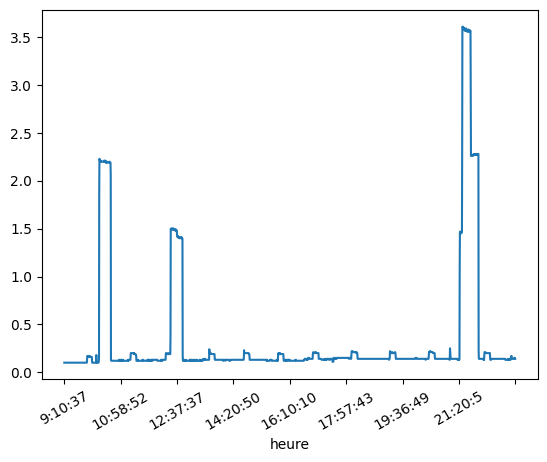

In [36]:
conso_day=conso_data[conso_data['days']==day].copy()  # no more error
conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)+':'+str(x.minute) +':'+str(x.second))
#=[x.hour for x in conso_day['dates']]
df= conso_day.set_index('heure')
df.tail(2000)['kWh'].plot()
plt.xticks(rotation=30);
#conso_day['heure']


In [37]:
conso_data

,Interval,kWh,sec,Wh,cumul(ms),dates,days
0,21934,0.16,21.934,164.128750,21934,2023-08-21 20:51:55.748825,21/08/23
1,21858,0.16,21.858,164.699424,43792,2023-08-21 20:52:17.606825,21/08/23
2,22001,0.16,22.001,163.628926,65793,2023-08-21 20:52:39.607825,21/08/23
3,21928,0.16,21.928,164.173659,87721,2023-08-21 20:53:01.535825,21/08/23
4,21891,0.16,21.891,164.451144,109612,2023-08-21 20:53:23.426825,21/08/23
...,...,...,...,...,...,...,...
1822960,24625,0.15,24.625,146.192893,44847418438,2025-01-21 22:28:32.252825,21/01/25
1822961,23999,0.15,23.999,150.006250,44847442437,2025-01-21 22:28:56.251825,21/01/25
1822962,24073,0.15,24.073,149.545134,44847466510,2025-01-21 22:29:20.324825,21/01/25
1822963,24182,0.15,24.182,148.871061,44847490692,2025-01-21 22:29:44.506825,21/01/25


In [38]:
df

,Interval,kWh,sec,Wh,cumul(ms),dates,days
heure,,,,,,,
0:0:15,26393,0.14,26.393,136.399803,44766521746,2025-01-21 00:00:15.560825,21/01/25
0:0:39,24360,0.15,24.360,147.783251,44766546106,2025-01-21 00:00:39.920825,21/01/25
0:1:4,24343,0.15,24.343,147.886456,44766570449,2025-01-21 00:01:04.263825,21/01/25
0:1:29,25165,0.14,25.165,143.055832,44766595614,2025-01-21 00:01:29.428825,21/01/25
0:1:55,25948,0.14,25.948,138.739016,44766621562,2025-01-21 00:01:55.376825,21/01/25
...,...,...,...,...,...,...,...
22:28:32,24625,0.15,24.625,146.192893,44847418438,2025-01-21 22:28:32.252825,21/01/25
22:28:56,23999,0.15,23.999,150.006250,44847442437,2025-01-21 22:28:56.251825,21/01/25
22:29:20,24073,0.15,24.073,149.545134,44847466510,2025-01-21 22:29:20.324825,21/01/25


In [39]:
# group by hour, df  = data of a chosen day
df_byhour = df[['days','kWh']].groupby('heure', sort=False)
kwh_byhour = df_byhour['kWh']



Max : 23/12/24 5.005
Min : 04/01/25 3.076


,Interval,kWh,sec,Wh,cumul(ms),dates,days,heure
1819898,26393,0.14,26.393,136.399803,44766521746,2025-01-21 00:00:15.560825,21/01/25,0:0:15
1819899,24360,0.15,24.360,147.783251,44766546106,2025-01-21 00:00:39.920825,21/01/25,0:0:39
1819900,24343,0.15,24.343,147.886456,44766570449,2025-01-21 00:01:04.263825,21/01/25,0:1:4
1819901,25165,0.14,25.165,143.055832,44766595614,2025-01-21 00:01:29.428825,21/01/25,0:1:29
1819902,25948,0.14,25.948,138.739016,44766621562,2025-01-21 00:01:55.376825,21/01/25,0:1:55
...,...,...,...,...,...,...,...,...
1822960,24625,0.15,24.625,146.192893,44847418438,2025-01-21 22:28:32.252825,21/01/25,22:28:32
1822961,23999,0.15,23.999,150.006250,44847442437,2025-01-21 22:28:56.251825,21/01/25,22:28:56
1822962,24073,0.15,24.073,149.545134,44847466510,2025-01-21 22:29:20.324825,21/01/25,22:29:20
1822963,24182,0.15,24.182,148.871061,44847490692,2025-01-21 22:29:44.506825,21/01/25,22:29:44


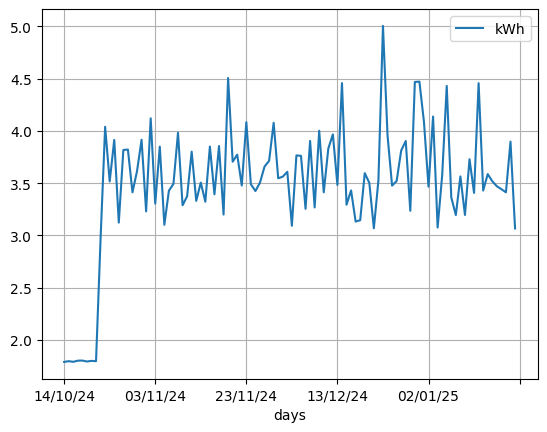

In [40]:

# premier kWh
if len(df)>1000:
    df.iloc[1000]['dates']
df.iloc[0].dates
df.dates.dt.time

# save data
df_grp.to_csv('df_grp.csv')
df.to_csv('df.csv')
df_grp.to_csv('conso_day_from_20230821.csv')

#df.info()
#df_grp.info()
df_grp.mean()
#df_grp.head()
df_grp.tail(14)
df_grp.tail(100).mean()
df_grp.tail(100).plot()
plt.grid()
# max min during last month
#print(df_grp.iloc[-31:-1])
df_grp.iloc[-31:-1].describe()

month = df_grp.iloc[-31:-1]['kWh']
print('Max :',month.idxmax(), max(month))
print('Min :',month.idxmin(), min(month))
conso_day


2025-01-21 00:00:15.560825	2025-01-21 08:36:09.500825	8h 35m 53s 	1000
2025-01-21 08:36:09.500825	2025-01-21 15:41:47.249825	7h 5m 37s 	2000
2025-01-21 15:41:47.249825	2025-01-21 22:01:00.015825	6h 19m 12s 	3000
2025-01-21 22:01:00.015825	2025-01-21 22:30:09.231825	0h 29m 9s 	67
<class 'pandas.core.frame.DataFrame'>
Index: 3067 entries, 1819898 to 1822964
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   3067 non-null   int64         
 1   kWh        3067 non-null   float64       
 2   sec        3067 non-null   float64       
 3   Wh         3067 non-null   float64       
 4   cumul(ms)  3067 non-null   int64         
 5   dates      3067 non-null   datetime64[ns]
 6   days       3067 non-null   object        
 7   heure      3067 non-null   object        
 8   hours      3067 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(3)
memory usage: 239.6+ KB


('21/01/25', <Axes: xlabel='hours'>)

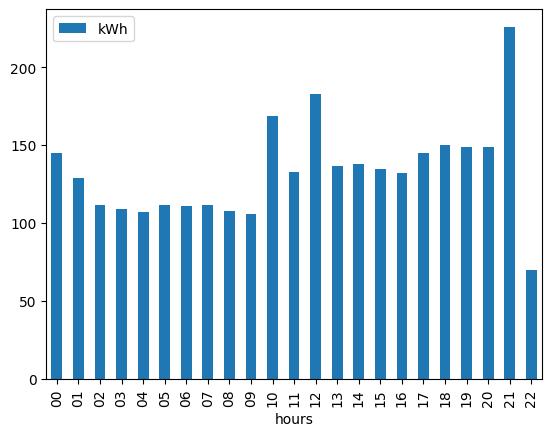

In [41]:

tranches = len(df)//1000
tranches+1
# temps de conso par tranches de 1kwh
for p in range(1,tranches+2):  # les 5 tranches de kWh consommés
    if len(df)>(p-1)*1000:
        period(p)
# conso temps réel
here = now.strftime('%H:%M:%S')
conso_jour=len(df['kWh'])
here, len(df)/1000, conso_jour
#add hours column for a chosen day
conso_hours = conso_day.copy()
conso_hours['hours']= conso_hours['dates'].dt.strftime('%H')
conso_hours.info()

conso_hours
# group conso of the day by hour
groupedbyhour = conso_hours[['hours','kWh']].groupby('hours', sort=False)
list(groupedbyhour)
day, groupedbyhour.count().plot.bar()

In [42]:
df_grp

,kWh
days,
21/08/23,0.601
22/08/23,3.701
23/08/23,4.239
24/08/23,3.687
25/08/23,3.970
...,...
17/01/25,3.471
18/01/25,3.443
19/01/25,3.413


In [43]:
# select number of days to display
span = 30
#df_grp.tail(span)


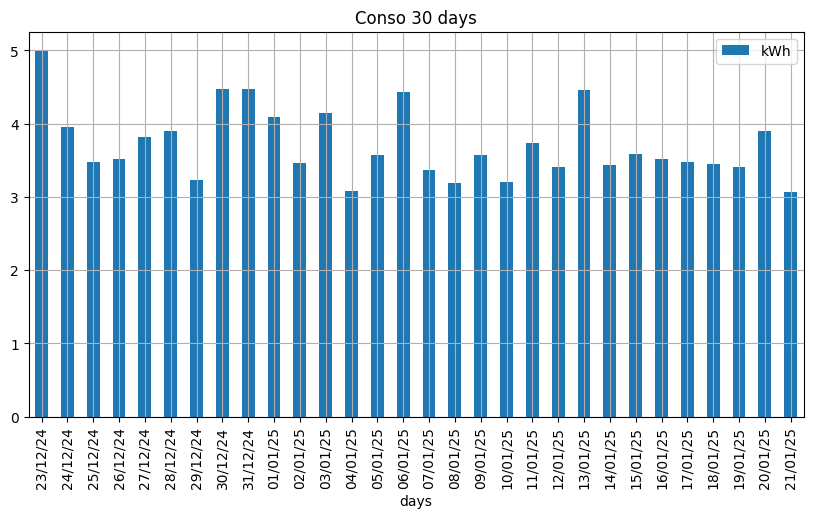

In [44]:

# Plot the figure without labels
df_grp.tail(span).plot.bar(grid=True, figsize=(10, 5), layout='tight') 
plt.title(f'Conso {span} days')
plt.xticks(rotation=90);


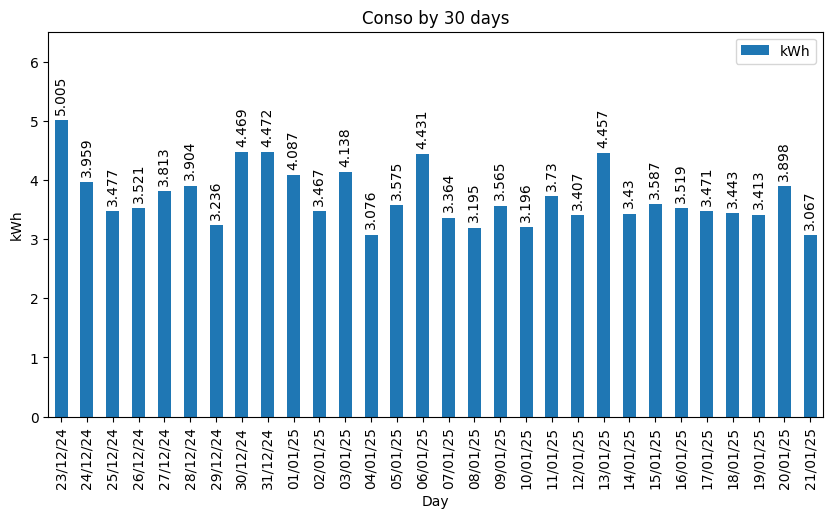

In [45]:
# Plot the figure with labels.
x_labels = list(df_grp.tail(span)['kWh'])
#x_labels
#fig, ax = plt.subplots(figsize=(2, 2), facecolor='lightskyblue',layout='constrained')
ax = df_grp.tail(span).plot(kind="bar", figsize=(10, 5), layout='tight')
ax.set_title(f"Conso by {span} days")
ax.set_xlabel("Day")
ax.set_ylabel("kWh")
ax.set_ymargin(0.3)
#ax.set_xticklabels(x_labels)
#fig.tight_layout()

rects = ax.patches

# Make some labels.
labels = [x_labels[i] for i in range(len(x_labels))]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    #print(height)
    ax.text(
        rect.get_x() + rect.get_width() / 2, height+.1, label, ha="center", va="bottom", rotation=90
    )

#plt.show()

In [46]:
y_labels = df_grp.tail(span)['kWh']
y_labels

days
23/12/24    5.005
24/12/24    3.959
25/12/24    3.477
26/12/24    3.521
27/12/24    3.813
28/12/24    3.904
29/12/24    3.236
30/12/24    4.469
31/12/24    4.472
01/01/25    4.087
02/01/25    3.467
03/01/25    4.138
04/01/25    3.076
05/01/25    3.575
06/01/25    4.431
07/01/25    3.364
08/01/25    3.195
09/01/25    3.565
10/01/25    3.196
11/01/25    3.730
12/01/25    3.407
13/01/25    4.457
14/01/25    3.430
15/01/25    3.587
16/01/25    3.519
17/01/25    3.471
18/01/25    3.443
19/01/25    3.413
20/01/25    3.898
21/01/25    3.067
Name: kWh, dtype: float64

In [47]:
x_labels=df_grp.tail(span).index
x_labels

Index(['23/12/24', '24/12/24', '25/12/24', '26/12/24', '27/12/24', '28/12/24',
       '29/12/24', '30/12/24', '31/12/24', '01/01/25', '02/01/25', '03/01/25',
       '04/01/25', '05/01/25', '06/01/25', '07/01/25', '08/01/25', '09/01/25',
       '10/01/25', '11/01/25', '12/01/25', '13/01/25', '14/01/25', '15/01/25',
       '16/01/25', '17/01/25', '18/01/25', '19/01/25', '20/01/25', '21/01/25'],
      dtype='object', name='days')

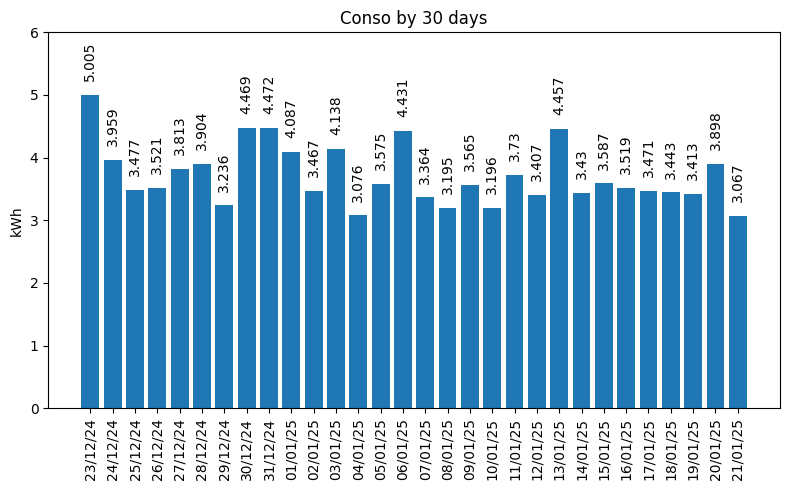

In [48]:
# Plot the figure with labels
# using bar_label
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_label_demo.html#sphx-glr-gallery-lines-bars-and-markers-bar-label-demo-py
fig, ax = plt.subplots(figsize=(8, 5), layout='tight')
bar_container = ax.bar(x_labels, y_labels)
#ax.set_xticks(x_labels, rotation=45)
ax.bar_label(bar_container, rotation=90, padding=10) #, fmt='{:,.0f}')
ax.set(ylabel='kWh', title=f'Conso by {span} days', ylim=(0, 6))
plt.xticks(rotation=90);


In [49]:
# figure manager

current=plt.get_current_fig_manager()
current.set_window_title('Conso by day')
#help(current.canvas)
#,facecolor='darkcyan')
#plt.style.use('fivethirtyeight')
#plt.style.use('ggplot')
#plt.style.use('dark_background')


<Figure size 640x480 with 0 Axes>

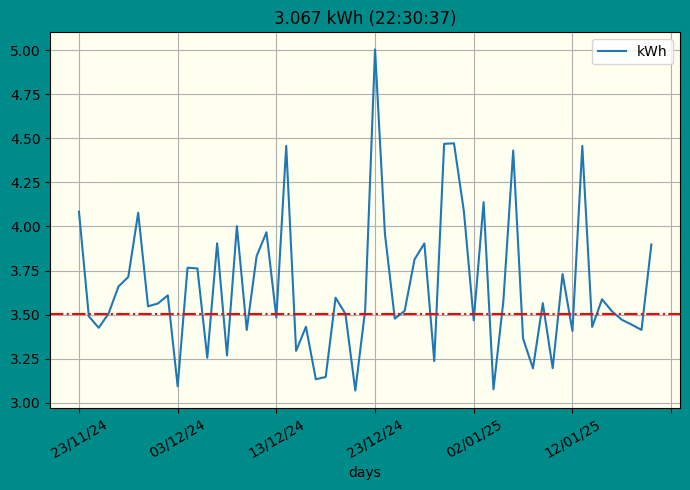

In [50]:
# pandas plot the day consos in the group
fig, ax = plt.subplots(facecolor='darkcyan', figsize=(7, 5), layout='tight')  # as argument
#or fig.patch.set_facecolor('darkcyan') # This changes the grey to white
ax.set_facecolor("ivory")

# 2 last months
df_grp.iloc[-60:-1].plot(grid=True,ax=ax, y=["kWh"])   #df.plot(x="Name", y=["Age", "Height(in cm)"], kind="bar", ax=ax)
plt.title(str(last)+' kWh ('+str(here)+')')
plt.axhline(y=np.nanmean(df_grp),c='red', ls='-.')
plt.xticks(rotation=30);  # https://ipython.readthedocs.io/en/stable/interactive/tips.html


Text(0.5, 1.0, 'Variations journalières')

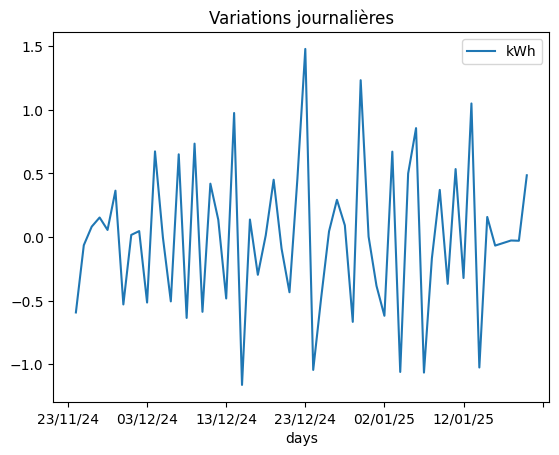

In [51]:
# variations journalières
df_grp.iloc[-60:-1].diff().plot()
plt.title('Variations journalières')

# Data from 21/08/23

In [52]:
# add hours column for conso_data (from 21/08/2023)
conso_days = conso_data.copy()
conso_days['hours']= conso_days['dates'].dt.strftime('%H')
conso_days

,Interval,kWh,sec,Wh,cumul(ms),dates,days,hours
0,21934,0.16,21.934,164.128750,21934,2023-08-21 20:51:55.748825,21/08/23,20
1,21858,0.16,21.858,164.699424,43792,2023-08-21 20:52:17.606825,21/08/23,20
2,22001,0.16,22.001,163.628926,65793,2023-08-21 20:52:39.607825,21/08/23,20
3,21928,0.16,21.928,164.173659,87721,2023-08-21 20:53:01.535825,21/08/23,20
4,21891,0.16,21.891,164.451144,109612,2023-08-21 20:53:23.426825,21/08/23,20
...,...,...,...,...,...,...,...,...
1822960,24625,0.15,24.625,146.192893,44847418438,2025-01-21 22:28:32.252825,21/01/25,22
1822961,23999,0.15,23.999,150.006250,44847442437,2025-01-21 22:28:56.251825,21/01/25,22
1822962,24073,0.15,24.073,149.545134,44847466510,2025-01-21 22:29:20.324825,21/01/25,22
1822963,24182,0.15,24.182,148.871061,44847490692,2025-01-21 22:29:44.506825,21/01/25,22


In [53]:
# example groupby with apply
df = pd.DataFrame({'Animal': ['Falcon', 'Falcon',
                              'Parrot', 'Parrot'],
                   'Max Speed': [380., 370., 24., 26.]})
df.groupby("Animal", group_keys=True)[['Max Speed']].apply(lambda x: x)
      

Max Speed
Animal             
Falcon 0      380.0
       1      370.0
Parrot 2       24.0
       3       26.0

In [54]:
import pandas as pd
df = pd.read_csv(r'C:\Users\jean\Downloads\only-bh-extreme-events-satellite.csv'
                  ,index_col=[0,1,2,3,4]
                  ,header=[0,1,2,3]
                  ,skipinitialspace=True
                  #,tupleize_cols=True
                ) 

df.columns = pd.MultiIndex.from_tuples(df.columns)
df.index.names

FrozenList(['wsid', 'lat', 'lon', 'start', 'prcp_24'])

In [55]:
index=df.columns.levels[0]
index

Index(['al', 'asn', 'cc', 'chnk', 'ci', 'ciwc', 'clwc', 'd', 'd2m', 'hcc',
       'istl1', 'istl2', 'istl3', 'istl4', 'lcc', 'lsrh', 'mcc', 'msl', 'o3',
       'p53.162', 'p54.162', 'p55.162', 'p56.162', 'p57.162', 'p58.162',
       'p59.162', 'p60.162', 'p61.162', 'p62.162', 'p63.162', 'p64.162',
       'p65.162', 'p66.162', 'p67.162', 'p68.162', 'p69.162', 'p70.162',
       'p71.162', 'p72.162', 'p73.162', 'p74.162', 'p75.162', 'p76.162',
       'p77.162', 'p78.162', 'p79.162', 'p80.162', 'p81.162', 'p82.162',
       'p83.162', 'p84.162', 'p85.162', 'p86.162', 'p87.162', 'p88.162',
       'p89.162', 'p90.162', 'p91.162', 'p92.162', 'pv', 'q', 'r', 'rsn', 'sd',
       'skt', 'sp', 'sr', 'src', 'sst', 'stl1', 'stl2', 'stl3', 'stl4',
       'swvl1', 'swvl2', 'swvl3', 'swvl4', 't', 't2m', 'tcc', 'tco3', 'tcw',
       'tcwv', 'tsn', 'u', 'u10', 'v', 'v10', 'vo', 'w', 'z'],
      dtype='object')

In [56]:
df_des = pd.DataFrame(
                            index=df.columns.levels[0],
                            columns=['count','mean','std','min','25','50','75','max']
                         )
df_des

,count,mean,std,min,25,50,75,max
al,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
asn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
chnk,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ci,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
v,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
v10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
vo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
w,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [57]:
groupallbyday = conso_days[['days','hours','kWh']].groupby(['days'], sort=False)
groupallbyday[['kWh']].count()  #.apply(lambda x: x))

,kWh
days,
21/08/23,601
22/08/23,3701
23/08/23,4239
24/08/23,3687
25/08/23,3970
...,...
17/01/25,3471
18/01/25,3443
19/01/25,3413


In [58]:
conso_days

,Interval,kWh,sec,Wh,cumul(ms),dates,days,hours
0,21934,0.16,21.934,164.128750,21934,2023-08-21 20:51:55.748825,21/08/23,20
1,21858,0.16,21.858,164.699424,43792,2023-08-21 20:52:17.606825,21/08/23,20
2,22001,0.16,22.001,163.628926,65793,2023-08-21 20:52:39.607825,21/08/23,20
3,21928,0.16,21.928,164.173659,87721,2023-08-21 20:53:01.535825,21/08/23,20
4,21891,0.16,21.891,164.451144,109612,2023-08-21 20:53:23.426825,21/08/23,20
...,...,...,...,...,...,...,...,...
1822960,24625,0.15,24.625,146.192893,44847418438,2025-01-21 22:28:32.252825,21/01/25,22
1822961,23999,0.15,23.999,150.006250,44847442437,2025-01-21 22:28:56.251825,21/01/25,22
1822962,24073,0.15,24.073,149.545134,44847466510,2025-01-21 22:29:20.324825,21/01/25,22
1822963,24182,0.15,24.182,148.871061,44847490692,2025-01-21 22:29:44.506825,21/01/25,22


In [59]:

# group all by day for all conso_days
groupallbydayhours = conso_days[['days','hours','kWh']].groupby(['days','hours'], sort=False)
# use apply to show the group
groupallbydayhours[['days','hours','kWh']].apply(lambda x: x)


days hours   kWh
days     hours                              
21/08/23 20    0        21/08/23    20  0.16
               1        21/08/23    20  0.16
               2        21/08/23    20  0.16
               3        21/08/23    20  0.16
               4        21/08/23    20  0.16
...                          ...   ...   ...
21/01/25 22    1822960  21/01/25    22  0.15
               1822961  21/01/25    22  0.15
               1822962  21/01/25    22  0.15
               1822963  21/01/25    22  0.15
               1822964  21/01/25    22  0.14

[1822965 rows x 3 columns]

In [60]:
groupallbyday.indices.keys()

dict_keys(['21/08/23', '22/08/23', '23/08/23', '24/08/23', '25/08/23', '26/08/23', '27/08/23', '28/08/23', '29/08/23', '30/08/23', '31/08/23', '01/09/23', '02/09/23', '03/09/23', '04/09/23', '05/09/23', '06/09/23', '07/09/23', '08/09/23', '09/09/23', '10/09/23', '11/09/23', '12/09/23', '13/09/23', '14/09/23', '15/09/23', '16/09/23', '17/09/23', '18/09/23', '19/09/23', '20/09/23', '21/09/23', '22/09/23', '23/09/23', '24/09/23', '25/09/23', '26/09/23', '27/09/23', '28/09/23', '29/09/23', '30/09/23', '01/10/23', '02/10/23', '03/10/23', '04/10/23', '05/10/23', '06/10/23', '07/10/23', '08/10/23', '09/10/23', '10/10/23', '11/10/23', '12/10/23', '13/10/23', '14/10/23', '15/10/23', '16/10/23', '17/10/23', '18/10/23', '19/10/23', '20/10/23', '21/10/23', '22/10/23', '23/10/23', '24/10/23', '25/10/23', '26/10/23', '27/10/23', '28/10/23', '29/10/23', '30/10/23', '31/10/23', '01/11/23', '02/11/23', '03/11/23', '04/11/23', '05/11/23', '06/11/23', '07/11/23', '08/11/23', '09/11/23', '10/11/23', '11/1

In [61]:
groupallbydayhours.indices.keys()

dict_keys([('21/08/23', '20'), ('21/08/23', '21'), ('21/08/23', '22'), ('21/08/23', '23'), ('22/08/23', '20'), ('22/08/23', '21'), ('22/08/23', '22'), ('22/08/23', '23'), ('22/08/23', '00'), ('22/08/23', '01'), ('22/08/23', '02'), ('22/08/23', '03'), ('22/08/23', '04'), ('22/08/23', '05'), ('22/08/23', '06'), ('22/08/23', '07'), ('22/08/23', '08'), ('22/08/23', '09'), ('22/08/23', '10'), ('22/08/23', '11'), ('22/08/23', '12'), ('22/08/23', '13'), ('22/08/23', '14'), ('22/08/23', '15'), ('22/08/23', '16'), ('22/08/23', '17'), ('22/08/23', '18'), ('22/08/23', '19'), ('23/08/23', '20'), ('23/08/23', '21'), ('23/08/23', '22'), ('23/08/23', '23'), ('23/08/23', '00'), ('23/08/23', '01'), ('23/08/23', '02'), ('23/08/23', '03'), ('23/08/23', '04'), ('23/08/23', '05'), ('23/08/23', '06'), ('23/08/23', '07'), ('23/08/23', '08'), ('23/08/23', '09'), ('23/08/23', '10'), ('23/08/23', '11'), ('23/08/23', '12'), ('23/08/23', '13'), ('23/08/23', '14'), ('23/08/23', '15'), ('23/08/23', '16'), ('23/08/2

In [62]:
grp_by_day = groupallbyday.count()
grp_by_day

,hours,kWh
days,,
21/08/23,601,601
22/08/23,3701,3701
23/08/23,4239,4239
24/08/23,3687,3687
25/08/23,3970,3970
...,...,...
17/01/25,3471,3471
18/01/25,3443,3443
19/01/25,3413,3413


In [63]:
grp_by_day['kWh'].cumsum()

days
21/08/23        601
22/08/23       4302
23/08/23       8541
24/08/23      12228
25/08/23      16198
             ...   
17/01/25    1809144
18/01/25    1812587
19/01/25    1816000
20/01/25    1819898
21/01/25    1822965
Name: kWh, Length: 520, dtype: int64

In [64]:
grp_by_dayhours = groupallbydayhours.count()
grp_by_dayhours

kWh
days     hours     
21/08/23 20      23
         21     238
         22     211
         23     129
22/08/23 00     130
...             ...
21/01/25 18     150
         19     149
         20     149
         21     226
         22      70

[12459 rows x 1 columns]

In [65]:
grp_by_dayhours['kWh'].cumsum()

days      hours
21/08/23  20            23
          21           261
          22           472
          23           601
22/08/23  00           731
                    ...   
21/01/25  18       1822371
          19       1822520
          20       1822669
          21       1822895
          22       1822965
Name: kWh, Length: 12459, dtype: int64

In [66]:
grp_by_dayhours['cumsum'] = grp_by_dayhours.groupby(level=0)['kWh'].cumsum()
grp_by_dayhours['diff'] = grp_by_dayhours.groupby(level=0)['kWh'].diff()
# or
grp_by_dayhours['cumsum'] = grp_by_dayhours.groupby(['days'])['kWh'].cumsum()
grp_by_dayhours['diff'] = grp_by_dayhours.groupby(['days'])['kWh'].diff()
grp_by_dayhours

kWh  cumsum   diff
days     hours                    
21/08/23 20      23      23    NaN
         21     238     261  215.0
         22     211     472  -27.0
         23     129     601  -82.0
22/08/23 00     130     130    NaN
...             ...     ...    ...
21/01/25 18     150    2473    5.0
         19     149    2622   -1.0
         20     149    2771    0.0
         21     226    2997   77.0
         22      70    3067 -156.0

[12459 rows x 3 columns]

In [67]:
today, grp_by_dayhours.loc[today]

('21/01/25',
        kWh  cumsum   diff
 hours                    
 00     145     145    NaN
 01     129     274  -16.0
 02     112     386  -17.0
 03     109     495   -3.0
 04     107     602   -2.0
 05     112     714    5.0
 06     111     825   -1.0
 07     112     937    1.0
 08     108    1045   -4.0
 09     106    1151   -2.0
 10     169    1320   63.0
 11     133    1453  -36.0
 12     183    1636   50.0
 13     137    1773  -46.0
 14     138    1911    1.0
 15     135    2046   -3.0
 16     132    2178   -3.0
 17     145    2323   13.0
 18     150    2473    5.0
 19     149    2622   -1.0
 20     149    2771    0.0
 21     226    2997   77.0
 22      70    3067 -156.0)

Text(0.5, 1.0, 'Cumul journalier')

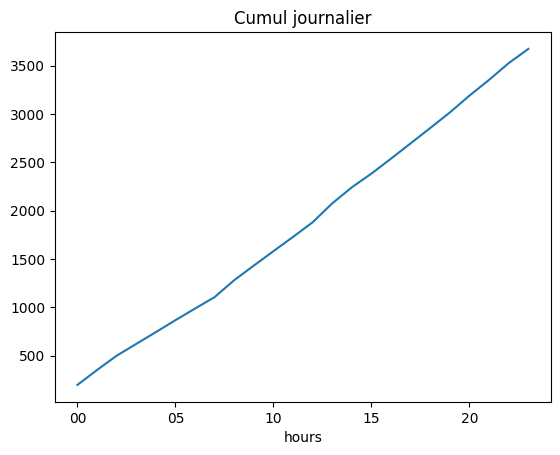

In [68]:
# progression sans surprise
grp_by_dayhours.loc['26/08/24']['cumsum'].plot()
plt.title('Cumul journalier')

Text(0.5, 1.0, 'Variation horaire')

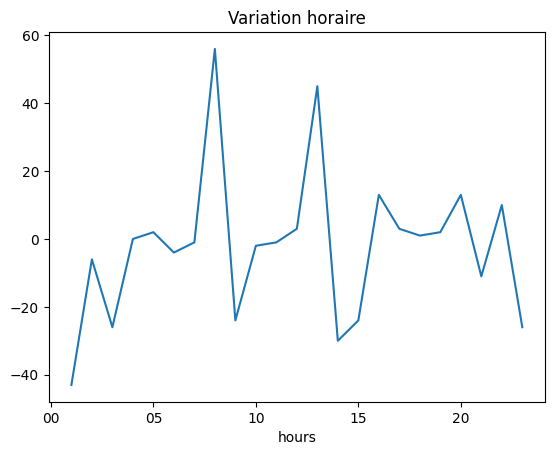

In [69]:
# plus parlant
grp_by_dayhours.loc['26/08/24']['diff'].plot()
plt.title(r'Variation horaire')

In [70]:
# count number of days since 21/08/2023
# https://stackoverflow.com/questions/45972388/count-my-multi-index-length-in-a-dataframe-pandas
n = len(grp_by_dayhours.index.levels[0].unique())
# or
n = len(grp_by_dayhours.index.levels[0])
# or
n = grp_by_dayhours.index.levshape[0]  # levshape -> (371,24)
n

520

In [71]:
df_grp.tail(n)['kWh'].describe()


count    520.000000
mean       3.505702
std        0.676520
min        0.601000
25%        3.346750
50%        3.610000
75%        3.877000
max        5.088000
Name: kWh, dtype: float64

In [72]:
maxday = df_grp.tail(n)['kWh'].idxmax()

Text(0.5, 1.0, '520 days')

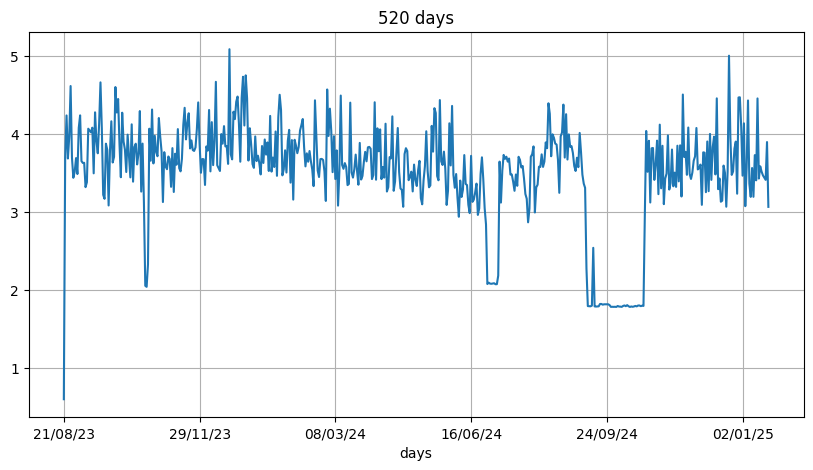

In [73]:
# show conso in span 
span = n
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.title(f'{span} days')

Text(0.5, 1.0, '400 days')

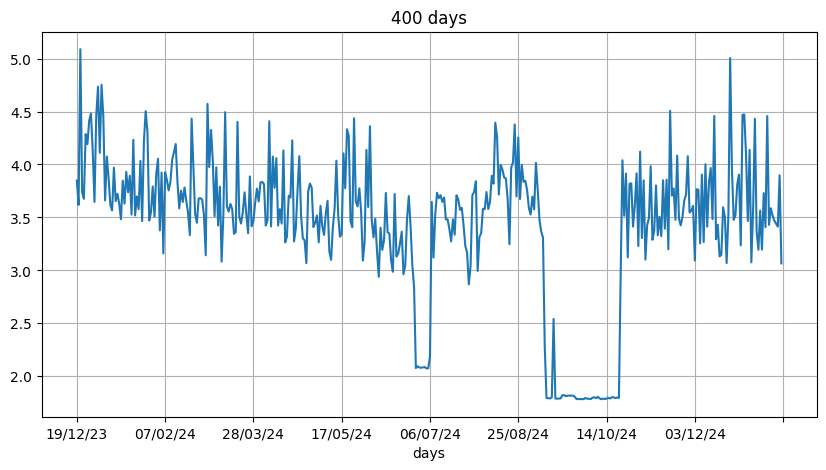

In [74]:
# show conso in span 
span = 400
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.title(f'{span} days')

In [75]:
df_grp['kWh']

days
21/08/23    0.601
22/08/23    3.701
23/08/23    4.239
24/08/23    3.687
25/08/23    3.970
            ...  
17/01/25    3.471
18/01/25    3.443
19/01/25    3.413
20/01/25    3.898
21/01/25    3.067
Name: kWh, Length: 520, dtype: float64

In [76]:
df_grp.describe()

,kWh
count,520.000000
mean,3.505702
std,0.676520
min,0.601000
25%,3.346750
50%,3.610000
75%,3.877000
max,5.088000


array([[<Axes: title={'center': 'kWh'}>]], dtype=object)

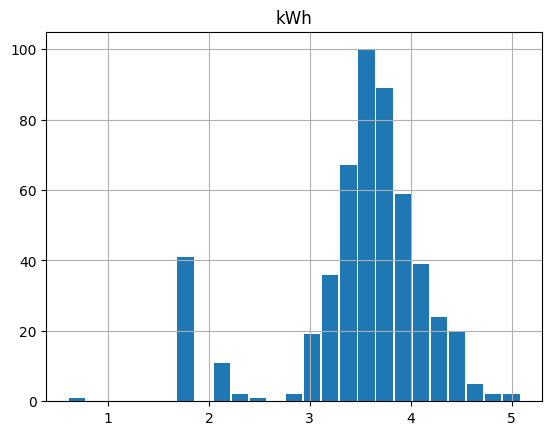

In [77]:
# répartition des consos de 1 à 5 kWh par jour
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html
# histtype{'bar', 'barstacked', 'step', 'stepfilled'}, default: 'bar'
df_grp.hist(bins=25, density=False, histtype='bar',rwidth=0.9, align='mid')

In [78]:
df_grp.tail(span)['kWh']

days
19/12/23    3.848
20/12/23    3.618
21/12/23    5.088
22/12/23    3.740
23/12/23    3.676
            ...  
17/01/25    3.471
18/01/25    3.443
19/01/25    3.413
20/01/25    3.898
21/01/25    3.067
Name: kWh, Length: 400, dtype: float64

# Conso par heure

In [79]:
day

'21/01/25'

In [80]:
grp_by_dayhours.loc[day]

,kWh,cumsum,diff
hours,,,
00,145,145,NaN
01,129,274,-16.0
02,112,386,-17.0
03,109,495,-3.0
04,107,602,-2.0
05,112,714,5.0
06,111,825,-1.0
07,112,937,1.0
08,108,1045,-4.0


In [81]:
# select a day to plot
day = '02/07/24'
day = today
len(grp_by_dayhours.loc[day])


23

In [82]:
l = range(1,len(grp_by_dayhours.loc[day])+1)
l

range(1, 24)

In [83]:
grp_by_dayhours.loc[day,'days'] = l #ist(1,len(grp_by_day.loc[day])+1)

In [84]:
grp_by_dayhours.loc[day,'days'].values

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23.])

In [85]:
grp_by_dayhours.loc[day,'days']

hours
00     1.0
01     2.0
02     3.0
03     4.0
04     5.0
05     6.0
06     7.0
07     8.0
08     9.0
09    10.0
10    11.0
11    12.0
12    13.0
13    14.0
14    15.0
15    16.0
16    17.0
17    18.0
18    19.0
19    20.0
20    21.0
21    22.0
22    23.0
Name: days, dtype: float64

In [86]:
### ????????????????????????
grp_by_dayhours.loc[day,'days'] = grp_by_dayhours.loc[day,'days'].values.astype('int64')

In [87]:
grp_by_dayhours.loc[day].info()

<class 'pandas.core.frame.DataFrame'>
Index: 23 entries, 00 to 22
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   kWh     23 non-null     int64  
 1   cumsum  23 non-null     int64  
 2   diff    22 non-null     float64
 3   days    23 non-null     float64
dtypes: float64(2), int64(2)
memory usage: 920.0+ bytes


In [88]:
grp_by_dayhours.loc[day,'days']

hours
00     1.0
01     2.0
02     3.0
03     4.0
04     5.0
05     6.0
06     7.0
07     8.0
08     9.0
09    10.0
10    11.0
11    12.0
12    13.0
13    14.0
14    15.0
15    16.0
16    17.0
17    18.0
18    19.0
19    20.0
20    21.0
21    22.0
22    23.0
Name: days, dtype: float64

In [89]:
day

'21/01/25'

In [90]:
grp_by_dayhours.loc[day]

,kWh,cumsum,diff,days
hours,,,,
00,145,145,NaN,1.0
01,129,274,-16.0,2.0
02,112,386,-17.0,3.0
03,109,495,-3.0,4.0
04,107,602,-2.0,5.0
05,112,714,5.0,6.0
06,111,825,-1.0,7.0
07,112,937,1.0,8.0
08,108,1045,-4.0,9.0


Text(0.5, 1.0, '21/01/25')

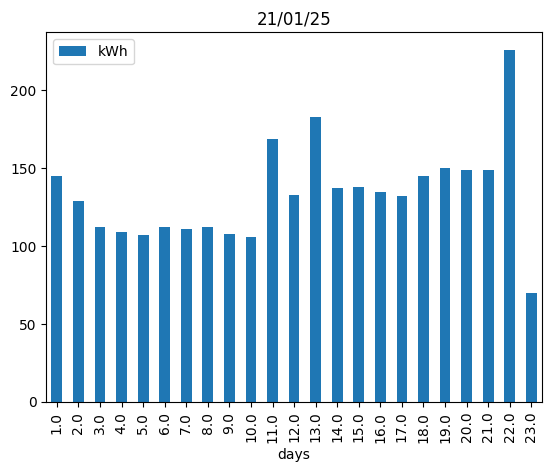

In [91]:
grp_by_dayhours.loc[day][['days','kWh']].plot.bar(x='days')
plt.title(f'{day}')

In [92]:
grp_by_dayhours.loc[day].index

Index(['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11',
       '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22'],
      dtype='object', name='hours')

# Conso du jour


In [93]:
groupedbyhour.count()

,kWh
hours,
00,145
01,129
02,112
03,109
04,107
05,112
06,111
07,112
08,108


In [94]:
day = '09/09/24'
day = maxday
#day = today
grp_by_dayhours.loc[day].kWh

hours
00    166
01    149
02    168
03    163
04    156
05    167
06    144
07    131
08    130
09    114
10    131
11    116
12    129
13    130
14    175
15    157
16    151
17    660
18    470
19    255
20    308
21    283
22    318
23    317
Name: kWh, dtype: int64

In [95]:
def conso_by_hour(day):
    global data
    # conso by hour
    #data = groupedbyhour.count().kWh
    data = grp_by_dayhours.loc[day].kWh

    # len(groupedbyhour)
    x = np.arange(1,len(data)+1)
    ymax = max(data)+5
    #groupedbyhour.count().plot(grid=True,xticks=x)
    fig, ax = plt.subplots(figsize=(8, 5), facecolor='darkcyan')

    plt.bar(x,data)
    #plt.grid()
    plt.tight_layout()
    plt.title(f'Conso by hour (W) {day} - Total {sum(data)}')
    plt.xlim(0,len(x)+1)
    #plt.xticks(rotation=30);
    #plt.ylim(0,ymax)

    rects = ax.patches

    # Make some labels.
    labels = [f"{i}" for i in data]
    fontfamily = {'calibri', 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height + 3, label, ha="center", va="bottom",
            fontfamily=fontfamily, fontsize=10, fontweight='bold', color='red'
        )


# 100 days

348.376

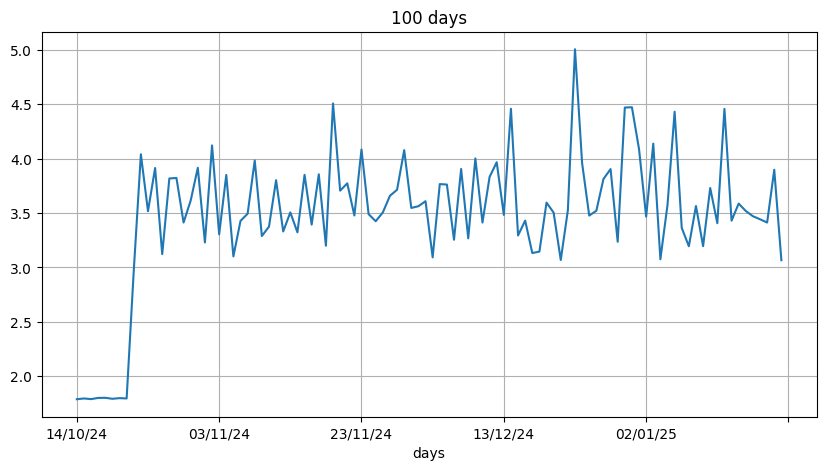

In [96]:
# show conso in span 
span = 100
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.title(f'{span} days')
sum(df_grp.tail(span)['kWh'])

In [97]:
df_grp.tail(1)

,kWh
days,
21/01/25,3.067


In [98]:
span = 1
#df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
#plt.title(f'{span} days')
sum(df_grp.tail(span)['kWh'])

3.067

In [99]:
#import timeit
#start = timeit.timeit()
#print("hello")
end = time.time()
print(end - start)

78.63684701919556


# Today

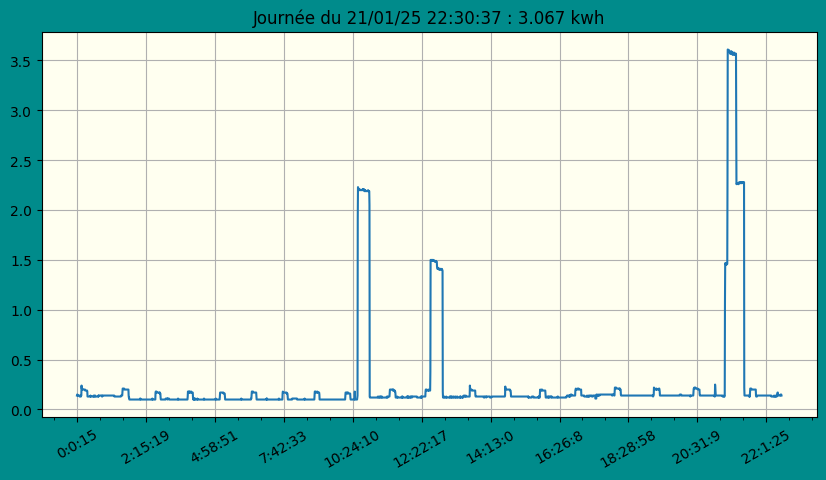

In [100]:
show(today,bgcolor='ivory')

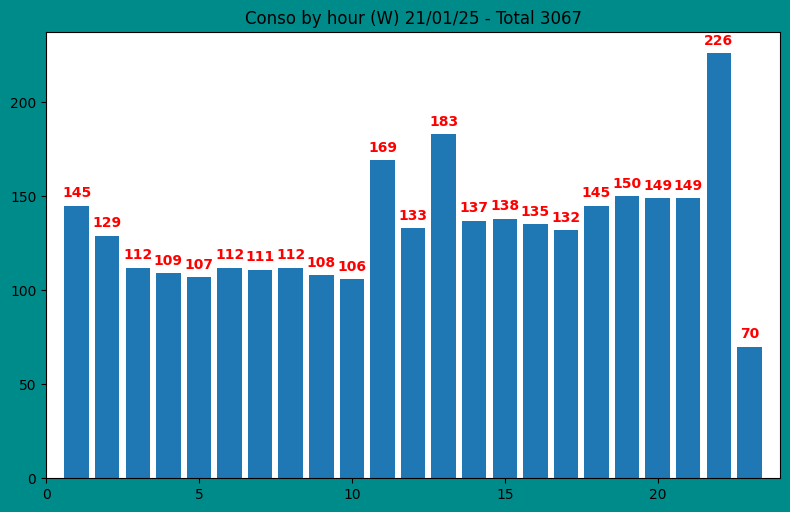

In [101]:
conso_by_hour(today)

In [102]:
day = '16/01/25'

('16/01/25', None)

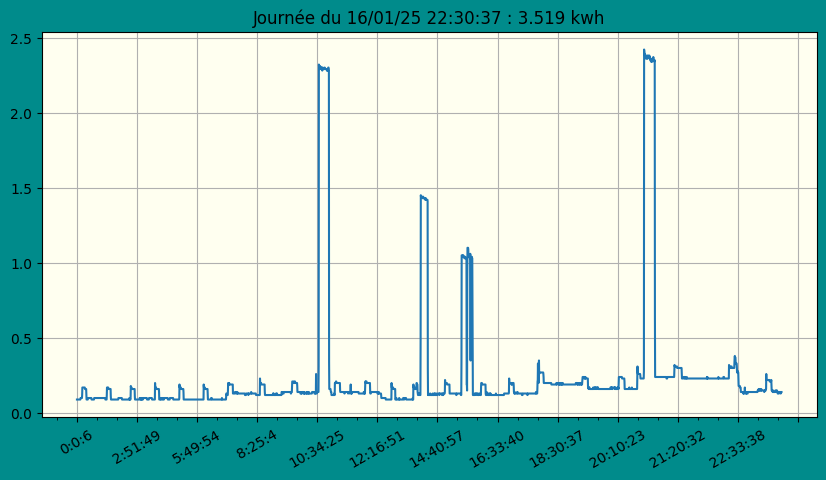

In [103]:
day, show(day,bgcolor='ivory')

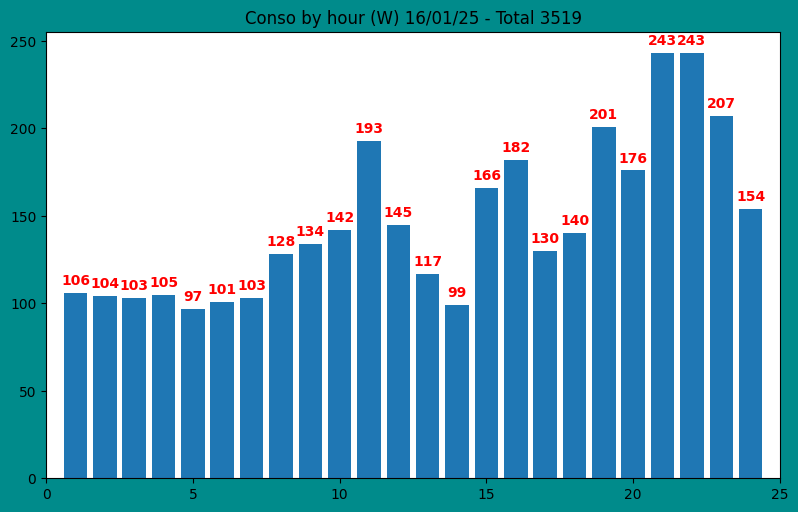

In [104]:
conso_by_hour(day)

In [105]:
maxday

'21/12/23'

('21/12/23', None)

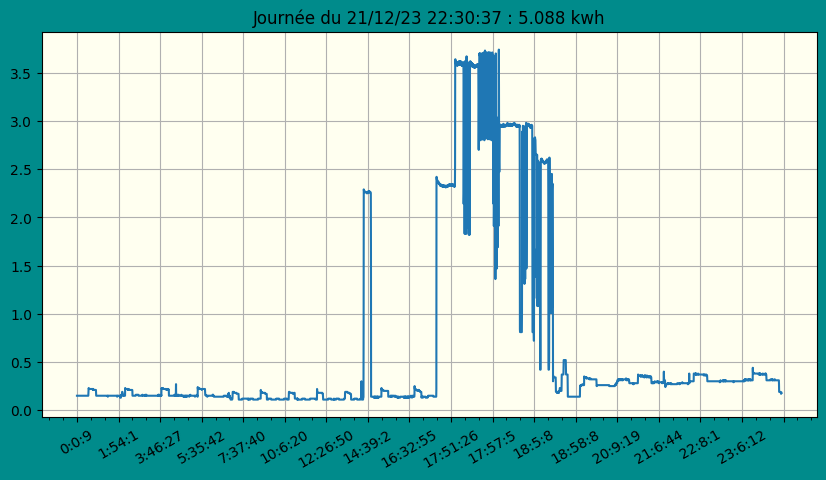

In [106]:
# retour vietnam 22/10/2024
#day = '22/10/24'
day = maxday
day, show(day,bgcolor='ivory')

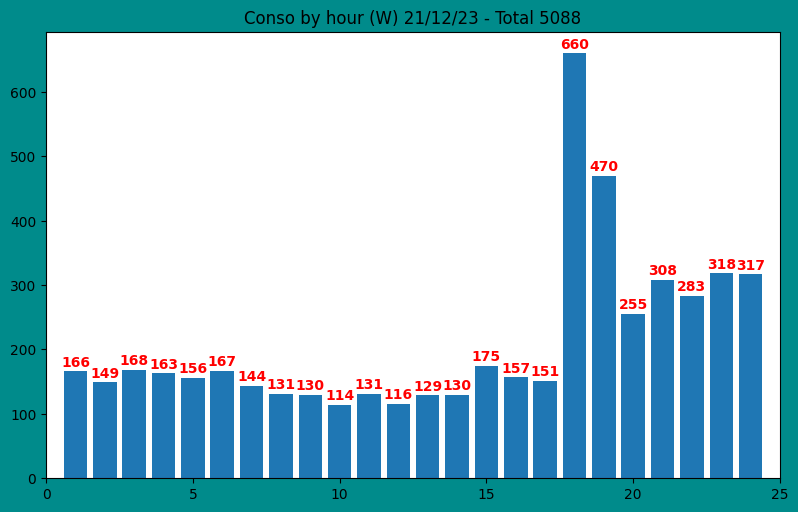

In [107]:
conso_by_hour(day)

In [108]:
sum(data)

5088

In [109]:
diff = grp_by_dayhours.loc[today]
diff


,kWh,cumsum,diff,days
hours,,,,
00,145,145,NaN,1.0
01,129,274,-16.0,2.0
02,112,386,-17.0,3.0
03,109,495,-3.0,4.0
04,107,602,-2.0,5.0
05,112,714,5.0,6.0
06,111,825,-1.0,7.0
07,112,937,1.0,8.0
08,108,1045,-4.0,9.0


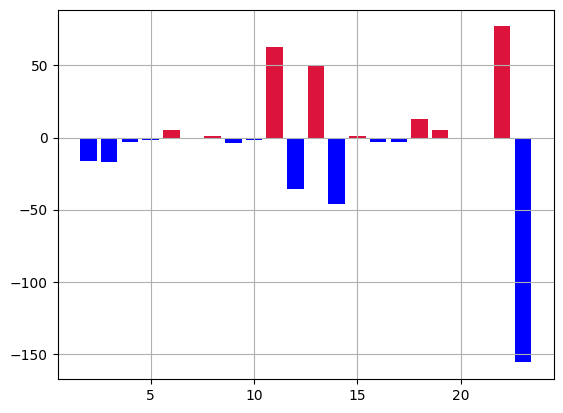

In [110]:
x = np.arange(1,len(diff)+1)

plt.bar(x,diff['diff'], color=np.where(diff['diff'] > 0, 'crimson', 'blue'))
plt.grid()

In [111]:
data

hours
00    166
01    149
02    168
03    163
04    156
05    167
06    144
07    131
08    130
09    114
10    131
11    116
12    129
13    130
14    175
15    157
16    151
17    660
18    470
19    255
20    308
21    283
22    318
23    317
Name: kWh, dtype: int64

<Axes: xlabel='hours'>

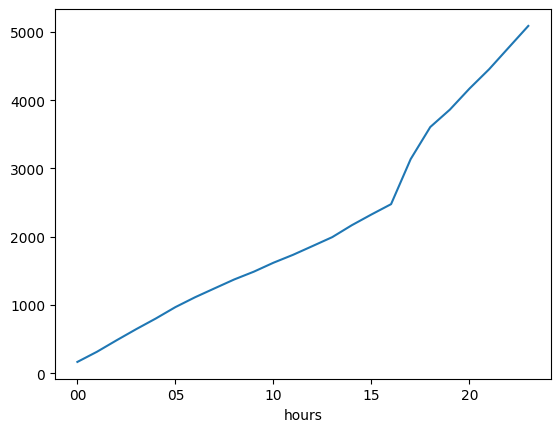

In [112]:
data.cumsum().plot()


<Axes: xlabel='hours'>

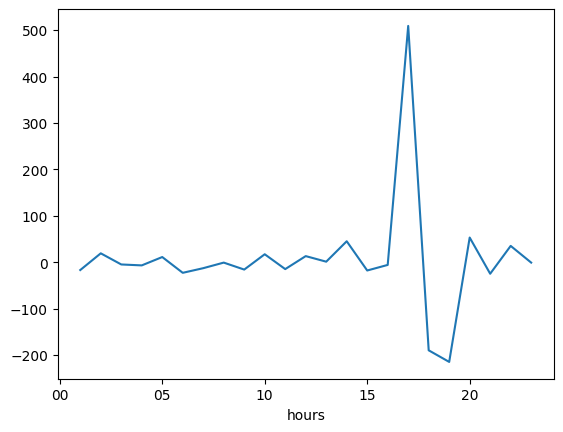

In [113]:
# evolution par heure
data.diff().plot()

In [114]:
data.diff().describe()

count     23.000000
mean       6.565217
std      126.121091
min     -215.000000
25%      -16.500000
50%       -5.000000
75%       15.000000
max      509.000000
Name: kWh, dtype: float64

<Axes: >

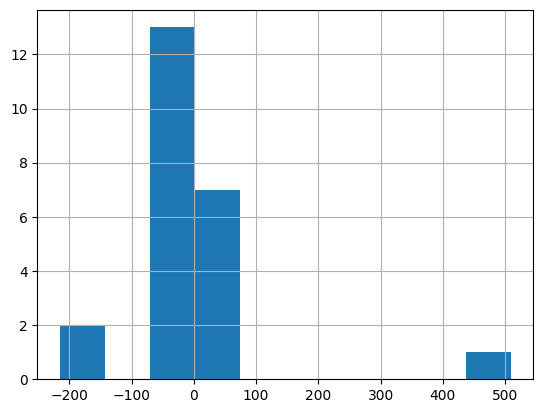

In [115]:
data.diff().hist()

# Test sauvegarde

In [116]:
import os
os.listdir(path='.')

['.git',
 '.gitignore',
 '.git_old',
 '.ipynb_checkpoints',
 '1row.flf',
 '5_days_meteo.ipynb',
 '8days.csv',
 '8days.pkl',
 '8days_dump.json',
 '8days_to_json.json',
 'advanced_expression.ipynb',
 'alphabeta_tree.ipynb',
 'amlich.ipynb',
 'amlich5.ipynb',
 'amlich_data.py',
 'amlich_functions.py',
 'amlich_lib.py',
 'AntPath.ipynb',
 'Apple.csv',
 'astronomie_def.ipynb',
 'atom_electronic_configuration.ipynb',
 'average_binding_energy_by_nucleons.ipynb',
 'bar_label.ipynb',
 'bell_curve.ipynb',
 'bitcoin_api.ipynb',
 'bitmap_convert.ipynb',
 'bitmap_structure.ipynb',
 'CAC40.csv',
 'chess_board.ipynb',
 'coindesk_api_client.ipynb',
 'collections.ipynb',
 'colormaps.ipynb',
 'conso.txt',
 'conso_by_hour.ipynb',
 'conso_data.csv',
 'conso_day_from_20230821.csv',
 'conso_jour.csv',
 'conso_jour.png',
 'conso_kwh.ipynb',
 'conso_kwh_reduced.ipynb',
 'conso_par_jour.csv',
 'covid19_france.ipynb',
 'cryptography_fernet.ipynb',
 'csv_readwrite.ipynb',
 'curves.ipynb',
 'dash_app001.ipynb',
 

In [117]:
# list to store files
res = []
# Iterate directory
for file in os.listdir('.'):
    # check only text files
    if file.endswith('.csv'):
        res.append(file)
        print(file)
#print(res)

8days.csv
Apple.csv
CAC40.csv
conso_data.csv
conso_day_from_20230821.csv
conso_jour.csv
conso_par_jour.csv
data_temp16122022.csv
demain.csv
df.csv
df_grp.csv
DowJones.csv
EURUSD.csv
Ford.csv
karaoke.csv
ligue1_2020_27.csv
Nasdaq.csv
Nikkei.csv
planete.csv
saturn_bodies.csv
saturn_rings.csv
SMSSpamCollection.csv
table-indicateurs-open-data-dep-2023-06-30-17h59.csv
table-indicateurs-open-data-france-2023-06-30-17h59.csv
temp_humidity.csv
Tesla.csv
titanic.csv
Toyota.csv
VNDUSD.csv
WA_Fn-UseC_-Telco-Customer-Churn.csv
week.csv


In [118]:
#conso_byhour(day)

In [119]:
# save to file
import pickle
path = r'../consobyhour.pkl'
with open(path,'wb') as file:
    pickle.dump(data, file)

# plot any day


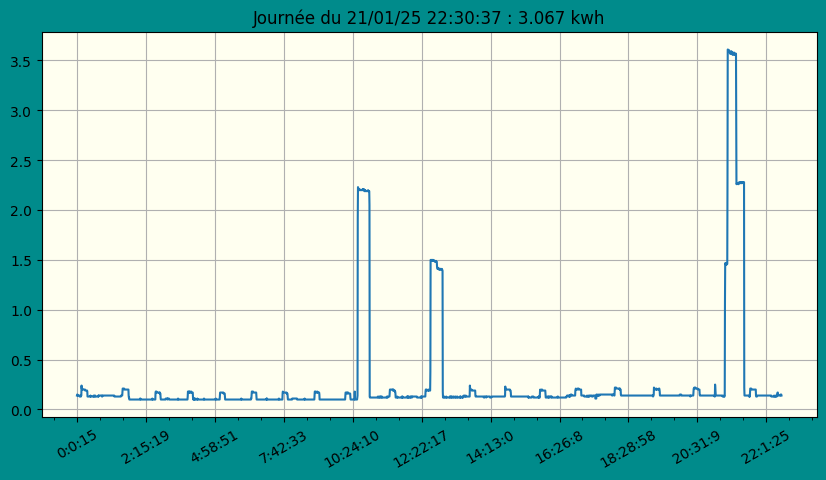

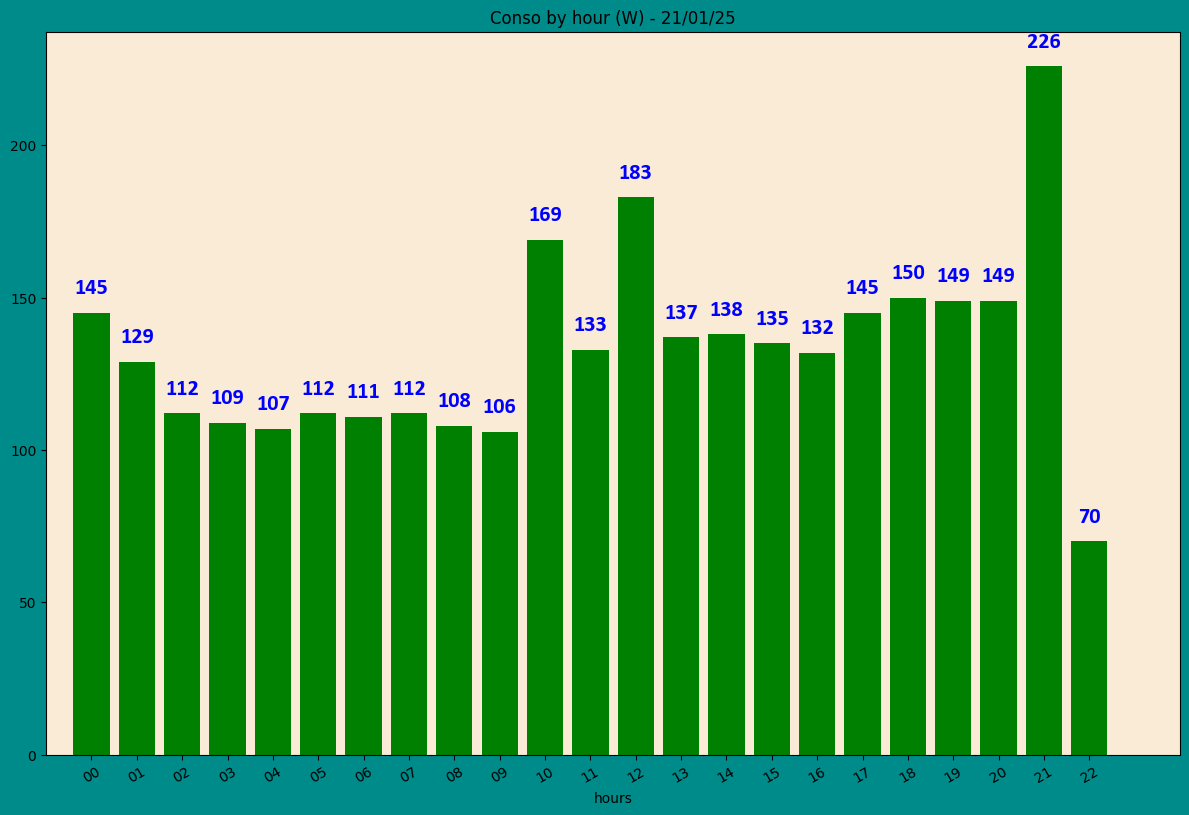

In [120]:
day = '27/10/24'
day = today
show(day,pltcolor='darkcyan')
conso_byhour(day)

In [121]:
month.describe()


count    30.000000
mean      3.727700
std       0.466457
min       3.076000
25%       3.433250
50%       3.545500
75%       3.945250
max       5.005000
Name: kWh, dtype: float64

<Axes: >

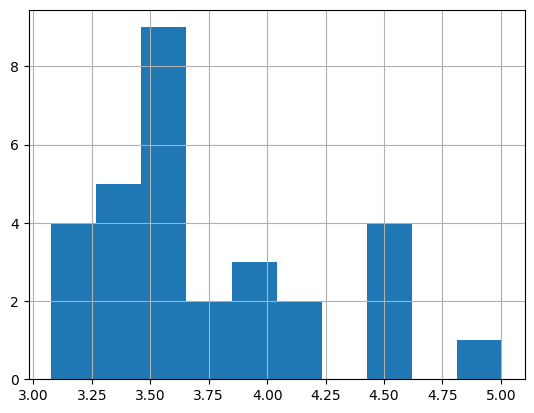

In [122]:
month.hist()

<Axes: xlabel='days'>

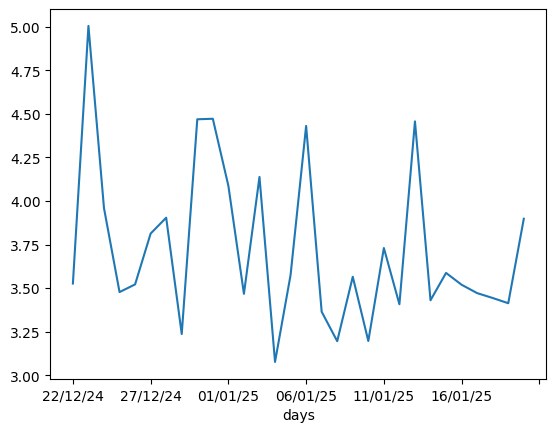

In [123]:
month.plot()

In [124]:
# date with max conso in 1 month
month.idxmax()

'23/12/24'

In [125]:
# plot month day max conso (télévision de 11h à 23h)
day = month.idxmax()
#day = '27/10/2024'
day

'23/12/24'

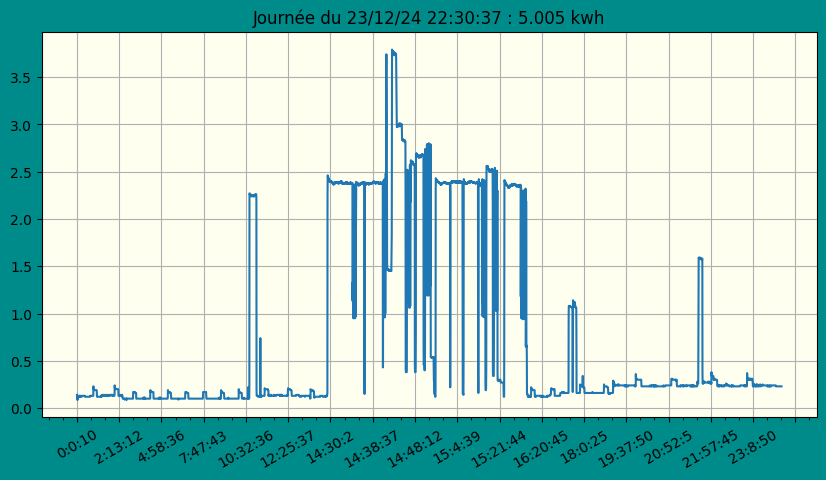

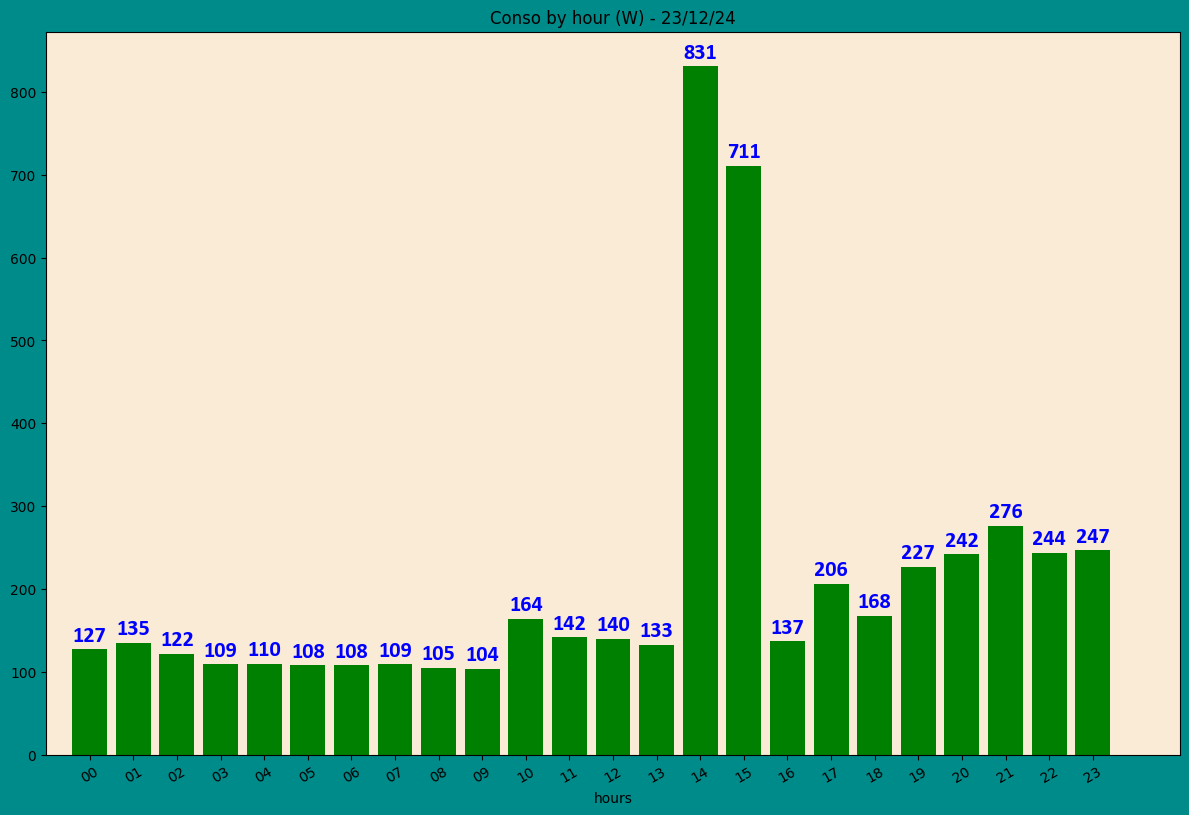

In [126]:
show(day,pltcolor='darkcyan')
conso_byhour(day)

In [127]:
grp_by_dayhours

kWh  cumsum   diff  days
days     hours                          
21/08/23 20      23      23    NaN   NaN
         21     238     261  215.0   NaN
         22     211     472  -27.0   NaN
         23     129     601  -82.0   NaN
22/08/23 00     130     130    NaN   NaN
...             ...     ...    ...   ...
21/01/25 18     150    2473    5.0  19.0
         19     149    2622   -1.0  20.0
         20     149    2771    0.0  21.0
         21     226    2997   77.0  22.0
         22      70    3067 -156.0  23.0

[12459 rows x 4 columns]

In [128]:
grp_by_dayhours.loc[month.idxmax()]

,kWh,cumsum,diff,days
hours,,,,
00,127,127,NaN,NaN
01,135,262,8.0,NaN
02,122,384,-13.0,NaN
03,109,493,-13.0,NaN
04,110,603,1.0,NaN
05,108,711,-2.0,NaN
06,108,819,0.0,NaN
07,109,928,1.0,NaN
08,105,1033,-4.0,NaN


In [129]:
grp_by_dayhours.columns

Index(['kWh', 'cumsum', 'diff', 'days'], dtype='object')

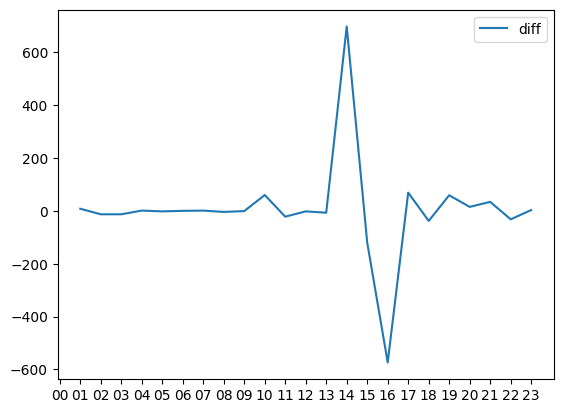

In [130]:
# diff
plt.plot(grp_by_dayhours.loc[month.idxmax()]['diff'],label=grp_by_dayhours.columns[2])
plt.legend()

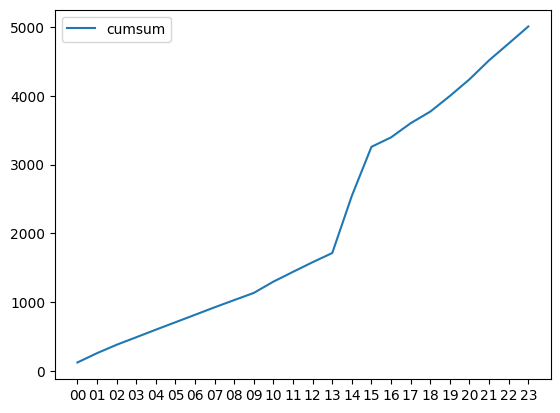

In [131]:
# cumsum
plt.plot(grp_by_dayhours.loc[month.idxmax()]['cumsum'],label=grp_by_dayhours.columns[1])
plt.legend()

In [132]:
# 41 s
# file to big to git sync

# create .gitignore
filename=r'../conso_data.csv'
#conso_data.to_csv(filename)
#43.6s size 140128 kB